Hyperparameter tuning and model validation

In [1]:
from e3fp.fingerprint.fprint import Fingerprint
from e3fp.fingerprint.fprint import CountFingerprint
from e3fp.fingerprint.db import FingerprintDatabase
from e3fp.fingerprint.metrics.array_metrics import tanimoto
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import pickle
from scipy.sparse import csr_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils import resample
from xgboost import XGBRegressor
import xgboost as xgb

In [2]:
logP = pickle.load(open("logp_df.p", "rb"))

In [3]:
logP['cprint'] = logP.fingerprint.apply(CountFingerprint.from_fingerprint)

In [4]:
logP.cprint[1].to_vector()

<1x2048 sparse matrix of type '<class 'numpy.uint16'>'
	with 17 stored elements in Compressed Sparse Row format>

In [5]:
X_sample, y_sample = resample(logP['cprint'], logP['logp'], n_samples=500, random_state=42)

In [6]:
X_sample

7270     (False, False, False, False, False, False, Fal...
860      (False, True, False, False, False, False, Fals...
5390     (False, False, False, False, False, False, Fal...
13418    (False, False, False, False, False, False, Fal...
5191     (False, False, False, False, False, False, Fal...
                               ...                        
5596     (False, False, False, False, False, False, Fal...
5801     (False, False, False, False, False, False, Fal...
2806     (False, False, False, False, False, False, Fal...
537      (False, False, False, False, False, False, Fal...
5986     (False, False, False, False, False, False, Fal...
Name: cprint, Length: 500, dtype: object

In [7]:


X_sample_db = FingerprintDatabase(fp_type=CountFingerprint, name="X_sample")
X_sample_db.add_fingerprints(X_sample.values)
X_sample_db_fold = X_sample_db.fold(1024)

In [8]:
X_sample_db_fold.array[0]

<1x1024 sparse matrix of type '<class 'numpy.uint16'>'
	with 16 stored elements in Compressed Sparse Row format>

In [9]:
param = {
    'nthread': [4], #when use hyperthread, xgboost may become slower
    'objective': ['reg:squarederror'],
    'learning_rate': [0.05], #so called `eta` value
    'max_depth': [5, 6, 7],
    'min_child_weight': [11],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'n_estimators': [500, 1000, 1500], #number of trees, change it to 1000 for better results
    'missing':[-999],
    'seed': [42],
}

grid = GridSearchCV(XGBRegressor(), param_grid=param, cv=5, verbose=1)
grid.fit(X_sample_db_fold.array, y_sample)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             param_grid={'colsa

In [55]:
grid.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.05,
 'max_depth': 6,
 'min_child_weight': 11,
 'missing': -999,
 'n_estimators': 500,
 'nthread': 4,
 'objective': 'reg:squarederror',
 'seed': 42,
 'subsample': 0.7}

In [13]:
X_train, X_test, y_train, y_test = train_test_split(logP['cprint'], logP['logp'], test_size=0.2, random_state=42)

In [14]:
X_train_db = FingerprintDatabase(fp_type=CountFingerprint, name="X_train")
X_train_db.add_fingerprints(X_train.values)
X_train_db_fold = X_train_db.fold(1024)

In [15]:
clf = XGBRegressor(colsample_bytree=0.8,
 learning_rate=0.05,
 max_depth=6,
 min_child_weight=11,
 missing=-999,
 n_estimators=500,
 nthread=4,
 objective='reg:squarederror',
 seed=42,
 subsample=0.7)
clf.fit(X_train_db_fold.array, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=6, min_child_weight=11, missing=-999,
             monotone_constraints='()', n_estimators=500, n_jobs=4, nthread=4,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [16]:
X_test_db = FingerprintDatabase(fp_type=CountFingerprint, name="X_test")
X_test_db.add_fingerprints(X_test.values)
X_test_db_fold = X_test_db.fold(1024)

y_pred = clf.predict(X_test_db_fold.array)

In [17]:
r2_score(y_pred, y_test)

0.827232163921201

In [18]:
db = FingerprintDatabase(fp_type=CountFingerprint, name="logp")
db.add_fingerprints(logP.cprint)
db_fold = db.fold(1024)

In [19]:
logP['xgboost_logp'] = clf.predict(db_fold.array)

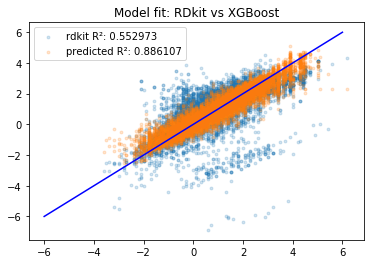

In [20]:
r2 = r2_score(logP['logp'], logP['rdkit_logp'])
pyplot.scatter(logP['logp'], logP['rdkit_logp'], alpha=0.2, s=8, label='rdkit R²: %f' % r2)

r2 = r2_score(logP['logp'], logP['xgboost_logp'])
pyplot.scatter(logP['logp'], logP['xgboost_logp'], alpha=0.2, s=8, label='predicted R²: %f' % r2)
pyplot.title('Model fit: RDkit vs XGBoost')
pyplot.legend()
pyplot.plot([-6, 6], [-6, 6], c="b")
pyplot.show()

Conclusion: The model performs ok, but can likely be improved upon.